<a href="https://colab.research.google.com/github/Refeena/ViolenceDetection/blob/main/ViolenceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd "/content/drive/MyDrive" 

/content/drive/MyDrive


In [ ]:
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset

real-life-violence-situations-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


 **IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow.keras.applications.mobilenet import MobileNet
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation, Dropout
import sys
import h5py

print ("Done!")

Done!


**HELPER FUNCTION** 


The function print_progress is used to print the amount of videos processed

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print.
    sys.stdout.write(msg)
    sys.stdout.flush()

print ("Done!")

Done!


**DATA LOADING** -
The directory to place the video dataset

In [ ]:
in_dir = "data"
in_dir = '/content/drive/MyDrive/Real Life Violence Dataset'
print(in_dir)
print ("Done!")

/content/drive/MyDrive/Real Life Violence Dataset
Done!


**DATA AUGMENTATION** 

In [ ]:
# Frame size  
img_size = 224

img_size_touple = (img_size, img_size)

# Number of channels (RGB)
num_channels = 3

# Flat frame size
img_size_flat = img_size * img_size * num_channels

# Number of classes for classification (Violence-No Violence)
num_classes = 2

# Number of files to train
_num_files_train = 1

# Number of frames per video
_images_per_file = 20

# Number of frames per training set
_num_images_train = _num_files_train * _images_per_file

# Video extension
video_exts = ".mp4"

print ("Done!")

Done!


**HELPER FUNCTION FOR ABSTRACTING VIDEO FRAMES**

Function to get 20 frames from a video file and convert the frame to a suitable format for the MobileNet Model.

In [ ]:
def get_frames(current_dir, file_name):
   
    '''if file_name[0]=="V":
        dir ="/Violence"
        in_file = os.path.join(current_dir+str(dir), file_name)
        print(in_file)
    else:
        dir ="/NonViolence"
        in_file = os.path.join(current_dir+str(dir), file_name)
        print(in_file)'''
    in_file = os.path.join(current_dir, file_name)
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
    '''print(success)
    print(image)'''
    count = 0

    while count<_images_per_file:
        '''cv2.imwrite("frame%d.jpg" % count, image)'''          
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    resul = np.array(images)
    
    resul = (resul / 255.).astype(np.float16)
        
    return resul

print ("Done!")

Done!


**HELPER FUNCTION FOR DATA ANNOTATION**

In [ ]:
def label_video_names(in_dir):
    
    # list containing video names
    names = []
    # list containin video labels [1, 0] if it has violence and [0, 1] if not violence
    labels = []   
   
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:1] == 'V':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'NV':
                labels.append([0,1])
                names.append(file_name)
                     
    #Dictionary       
    c = list(zip(names,labels))
    # Suffle the data (names and labels)
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

print ("Done!")

Done!


In [ ]:
#DATA ANNOTATION
names, labels = label_video_names(in_dir)

print ("Done!")

Done!


In [ ]:
print(labels)
print(names)
print(len(names))

([1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [1, 0],

**PRE-TRAINED MODEL: MobileNet**

In [ ]:
image_model = MobileNet(include_top=True, weights='imagenet')

17235968/17225924 [==============================] - 0s 0us/step


**MODEL SUMMARY**

In [ ]:
image_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

[]

In [ ]:
# We will use the output of the layer prior to the final classification-layer
transfer_layer = image_model.get_layer('reshape_2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the MobileNet net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of MobileNet net have dimensions: ", transfer_values_size)

The input of the MobileNet net have dimensions: (224, 224)
The output of the selecter layer of MobileNet net have dimensions:  1000


**FUNCTION TO GET TRANSFER VALUES**

In [ ]:
def get_transfer_values(current_dir, file_name):
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
      
    # Pre-allocate output-array for transfer-values.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values 

**GENERATOR THAT PROCESS ONE VIDEO THROUGH MobileNet**

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)
    
    # Pre-allocate input-batch-array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

**FUNCTION TO SAVE TRANSFER VALUES**

In [ ]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('prueba1.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

             # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [ ]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('pruebavalidation1.h5', 'w') as f:
    
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
         # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

**DATASET SPLITING**

In [ ]:
training_set = int(len(names)*0.9)
test_set = int(len(names)*0.1)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [ ]:
%cd /content/drive/MyDrive
!pwd


/content/drive/MyDrive
/content/drive/MyDrive


**SAVING THE TRANSFER VALUES IN DISK BY PROCESSING ALL VIDEO FRAMES THROUGH MOBILENET**

In [ ]:
make_files(training_set)

/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_521.mp4
/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_103.mp4
- Progress: 0.1%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_642.mp4
- Progress: 0.1%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_260.mp4
- Progress: 0.2%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_517.mp4
- Progress: 0.2%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_576.mp4
- Progress: 0.3%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_753.mp4
- Progress: 0.3%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_989.mp4
- Progress: 0.4%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_908.mp4
- Progress: 0.4%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_208.mp4
- Progress: 0.5%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_859.mp4
- Progress: 0.6%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_629.

In [ ]:
make_files_test(test_set)

/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_170.mp4
/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_78.mp4
- Progress: 0.5%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_566.mp4
- Progress: 1.0%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_915.mp4
- Progress: 1.5%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_320.mp4
- Progress: 2.0%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_926.mp4
- Progress: 2.5%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_736.mp4
- Progress: 3.0%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_775.mp4
- Progress: 3.5%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_774.mp4
- Progress: 4.0%/content/drive/MyDrive/Real Life Violence Dataset/Violence/V_98.mp4
- Progress: 4.5%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/NV_872.avi
- Progress: 5.0%/content/drive/MyDrive/Real Life Violence Dataset/NonViolence/N

**LOADING THE CACHED TRANSFER VALUES INTO MEMORY**

We have to load those transfer values into memory in order to train the LSTM net.Training the LSTM in different ways in order to see which way gets the best accuracy, if you didn't save the transfer values into disk you would have to process the whole videos each training. It's very time consuming processing.

In [ ]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('/content/drive/MyDrive/prueba1.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('/content/drive/MyDrive/pruebavalidation1.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [ ]:
data, target = process_alldata_training()

In [ ]:
data_test, target_test = process_alldata_test()

**LSTM ARCHITECTURE**

In LSTM architecture we take into account the dimensions of the transfer values.

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout
chunk_size = 1000
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(2))
model.add(Activation('softmax'))
print(model.summary())

model.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               3098624   
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 50)                51250     
                                                                 
 activation_1 (Activation)   (None, 50)                0         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1

In [ ]:
len(target)

1798

In [ ]:
len(data_test)

199

In [ ]:
epoch = 100
batchS = 500 #500

history = model.fit(np.array(data[0:1750]), np.array(target[0:1750]), epochs=epoch,
                    validation_data=(np.array(data[1750:]), np.array(target[1750:])), 
                    batch_size=batchS, verbose=2)

Epoch 1/100
4/4 - 10s - loss: 0.2441 - accuracy: 0.6103 - val_loss: 0.1334 - val_accuracy: 0.8333 - 10s/epoch - 2s/step
Epoch 2/100
4/4 - 7s - loss: 0.1047 - accuracy: 0.8634 - val_loss: 0.0819 - val_accuracy: 0.8542 - 7s/epoch - 2s/step
Epoch 3/100
4/4 - 7s - loss: 0.0623 - accuracy: 0.9183 - val_loss: 0.0462 - val_accuracy: 0.9375 - 7s/epoch - 2s/step
Epoch 4/100
4/4 - 7s - loss: 0.0395 - accuracy: 0.9480 - val_loss: 0.0346 - val_accuracy: 0.9792 - 7s/epoch - 2s/step
Epoch 5/100
4/4 - 7s - loss: 0.0217 - accuracy: 0.9760 - val_loss: 0.0357 - val_accuracy: 0.9583 - 7s/epoch - 2s/step
Epoch 6/100
4/4 - 7s - loss: 0.0129 - accuracy: 0.9897 - val_loss: 0.0284 - val_accuracy: 0.9792 - 7s/epoch - 2s/step
Epoch 7/100
4/4 - 7s - loss: 0.0085 - accuracy: 0.9926 - val_loss: 0.0272 - val_accuracy: 0.9792 - 7s/epoch - 2s/step
Epoch 8/100
4/4 - 7s - loss: 0.0066 - accuracy: 0.9954 - val_loss: 0.0315 - val_accuracy: 0.9583 - 7s/epoch - 2s/step
Epoch 9/100
4/4 - 7s - loss: 0.0065 - accuracy: 0.9931

In [ ]:
model.save('/content/drive/MyDrive/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/model/assets


**MODEL TESTING**

In [ ]:
result = model.evaluate(np.array(data_test), np.array(target_test))

7/7 [==============================] - 1s 78ms/step - loss: 0.0402 - accuracy: 0.9548


**Print the model accuracy**

In [ ]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.04022785648703575
accuracy 0.9547738432884216


**PLOTING ACCURACY VS EPOCH AND LOSS VS EPOCH**

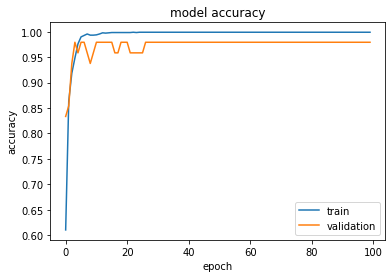

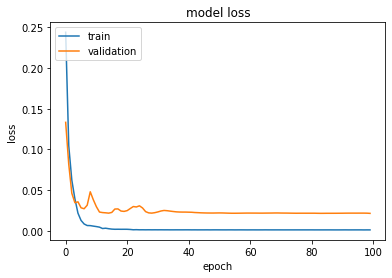

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

**VIDEO MACHINE**

The video machine is an interface between a Deep Learning Model and User. The system will take the input from the user and process it through the system. The system will hightlight the border with red color if violence is present otherwise green border will be added.

In [ ]:
in_dir_1 = '/content/drive/MyDrive/test'
print ("Done!")
print(in_dir_1)

#1,3,5,7-VIOLENCE VIDEO
#2,4,6,8-NON_VIOLENCE VIDEOS

Done!
/content/drive/MyDrive/test


In [ ]:
def video_names(in_dir_1):
    
    # list containing video names
    names1 = []

    for current_dir, dir_names,file_names in os.walk(in_dir_1):
        
        for file_name1 in file_names:
          
           names1.append(file_name1)

           #shuffle(names1)
                  
    return tuple(names1)

print ("Done!")

Done!


In [ ]:
# Storing in names1
names1 = video_names(in_dir_1)
print ("Done!")

print(names1)

Done!
('1.mp4', '7.mp4', '3.mp4', '5.mp4', '2.mp4', '4.mp4', '6.mp4', '8.mp4', 'violenceTest.mp4', 'violenceTest2.mp4', 'nonviolencetest.mp4')


In [ ]:
video_no=names1[8]
print(video_no)

violenceTest.mp4


In [ ]:
frames1 = get_frames(in_dir_1, video_no)
visible_frame = (frames1*255).astype('uint8')
#plt.imshow(visible_frame[10])
img_input=visible_frame[10]

In [ ]:
from PIL import Image, ImageOps
from numpy import asarray

def add_border(input_image, output_image, border, color=0):
    img = Image.open(input_image)
    if isinstance(border, int) or isinstance(border, tuple):
        bimg = ImageOps.expand(img, border=border, fill=color)
    else:
        raise RuntimeError('Border is not an integer or tuple!')
    bimg.save(output_image)

In [ ]:
gr_im= Image.fromarray(img_input).save('violence_1.jpg')
in_img = 'violence_1.jpg'

RESULT-VIOLENCE PRESENT


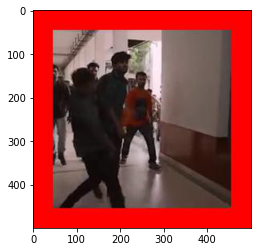

In [ ]:
video = get_transfer_values(in_dir_1, video_no)
video = video.reshape((1, video.shape[0], video.shape[1]))
label = np.argmax(model.predict(video))

if(label==1):
  print('RESULT-VIOLENCE NOT PRESENT')
  color_br='green'
else:
  print('RESULT-VIOLENCE PRESENT')
  color_br='red'

add_border(in_img ,output_image='violence_final.jpg',border=25,color=color_br)
# load the image
image = np.array(Image.open('violence_final.jpg').resize((500,500)))
# convert image to numpy array
data = asarray(image)
plt.imshow(data)